# Estimating Wind Speed Distribution with Weibull distribution

https://www.sciencedirect.com/science/article/abs/pii/S0167610599001221#:~:text=The%20Weibull%20distribution%20is%20a,for%20wind%20energy%20calculation%20purposes.

J.V. Seguro, T.W. Lambert,
Modern estimation of the parameters of the Weibull wind speed distribution for wind energy analysis,
Journal of Wind Engineering and Industrial Aerodynamics,
Volume 85, Issue 1,
2000,
Pages 75-84,
ISSN 0167-6105,
https://doi.org/10.1016/S0167-6105(99)00122-1.

Data from: https://a2e.energy.gov/ds/pluswind/plant.c0

In [1]:
import matplotlib.pyplot as plt
import torch 
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import csv
import numpy as np
from numpy import genfromtxt

In [2]:

my_data_1 = genfromtxt('plant.c0.2021.692.csv', delimiter=',')
my_data_2 = genfromtxt('plant.c0.2021.7501.csv', delimiter=',')
my_data = np.concatenate((my_data_1, my_data_2), axis=0)

In [3]:
wind_speeds = []

day = []
i = 1
while i < len(my_data):
    day.append(my_data[i][1])
    if i%24 == 0:
        wind_speeds.append(day)
        day = []
    i+=1

In [4]:
print(wind_speeds[10])

[6.818256968691746, 6.67273155749959, 6.673923397922959, 6.755255579440034, 6.927317360322236, 7.016899588073758, 7.066351377084856, 7.262616442874619, 7.413527749850109, 7.493501326877951, 7.698660563128446, 7.693614880706702, 7.514445516513845, 7.521236169727171, 7.6867979495737, 7.775669152999967, 7.414735330071134, 6.788338910401691, 5.8620463255056965, 5.945739653744187, 6.50274405943895, 7.037601618910473, 6.625423193198234, 6.898747930460855]


## Calculate Labels for training

https://www.kaggle.com/code/esrakrba/weibull-distribution-for-wind-speed/notebook

In [5]:
#definition of weibull distribution
def weibull (x,c,k):
    return (k / c) * (x / c)**(k - 1) * np.exp(-(x / c)**k)

In [6]:
# find k, c parameter
import math
import scipy as sc
def find_parameters(wind_speeds):
    k = (math.sqrt(np.mean(abs(wind_speeds - np.mean(wind_speeds))**2))/np.mean(wind_speeds))**-1.089
    gamma_f = math.exp(sc.special.gammaln(1+(1/k)))
    c = (np.mean(wind_speeds)/gamma_f)
    return [k,c]

In [7]:
print(find_parameters(wind_speeds[10]))

[17.28124475467969, 7.264201670696911]


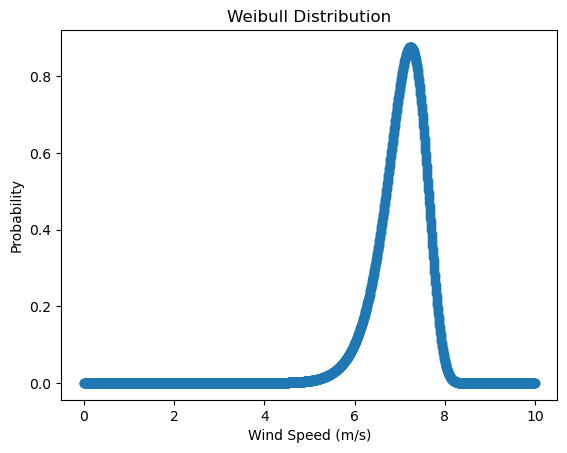

In [8]:
x_plot = []
y_plot = []
curr = 0

[k,c] = find_parameters(wind_speeds[10])
for i in range(0,2000):
    x_plot.append(curr)
    y_plot.append(weibull(curr,c,k))
    curr += 10./2000

    
plt.scatter(x_plot,y_plot)
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Probability")
plt.title("Weibull Distribution")
plt.show()

In [9]:
matching_c = []
matching_k = []
for i in wind_speeds:
    [k,c] = find_parameters(i)
    matching_c.append(c)
    matching_k.append(k)

## Summary Statistics? (how would this work here)

## Organise into Training & Testing Data

In [10]:
for i in range(0,len(wind_speeds)):
    for j in range(24):
        
        if math.isnan(wind_speeds[i][j]):
            wind_speeds[i][j] = 1.0
    if math.isnan(matching_c[i]):
        matching_c[i] = 0
    if math.isnan(matching_k[i]):
        matching_k[i] = 0
    wind_speeds[i] = np.array(wind_speeds[i])
    
x,y = np.array(wind_speeds), np.array(matching_c)
y = y.reshape(-1,1)
x_scaler = MinMaxScaler()
x_scaled = x_scaler.fit_transform(x)
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.33, random_state=42)

In [12]:
X_train = torch.from_numpy(x_train.astype(np.float32))
Y_train = torch.from_numpy(y_train.astype(np.float32))
X_test = torch.from_numpy(x_test.astype(np.float32))
Y_test = torch.from_numpy(y_test.astype(np.float32))

## Training

In [13]:
class LinearRegression(nn.Module):
  def __init__(self, input_dim: int, 
               hidden_dim: int, output_dim: int) -> None:
    super(LinearRegression, self).__init__()
    self.input_to_hidden = nn.Linear(input_dim, hidden_dim)
    self.hidden_layer_1 = nn.Linear(hidden_dim, hidden_dim)
    self.hidden_layer_2 = nn.Linear(hidden_dim, hidden_dim)
    self.hidden_to_output = nn.Linear(hidden_dim, output_dim)
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.input_to_hidden(x)
    x = self.hidden_layer_1(x)
    x = self.hidden_layer_2(x)
    x = self.hidden_to_output(x)
    return x

In [14]:
input_dim = X_train.shape[1]
hidden_dim = 2
batch_size = 10
num_workers = 4

model = LinearRegression(input_dim, hidden_dim, 1)
print(model)

LinearRegression(
  (input_to_hidden): Linear(in_features=24, out_features=2, bias=True)
  (hidden_layer_1): Linear(in_features=2, out_features=2, bias=True)
  (hidden_layer_2): Linear(in_features=2, out_features=2, bias=True)
  (hidden_to_output): Linear(in_features=2, out_features=1, bias=True)
)


In [15]:
loss_func = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [16]:
e = []
l = []
for epoch in range(0,500):  
    predict_y = model(X_train) 
    loss = loss_func(predict_y, Y_train) 
    optimizer.zero_grad() 
    loss.backward() 

    optimizer.step() 
    print('epoch {}, loss function {}'.format(epoch, loss.item()))
    e.append(epoch)
    l.append(loss.item())
    

epoch 0, loss function 0.18197543919086456
epoch 1, loss function 0.05626508221030235
epoch 2, loss function 0.029397027567029
epoch 3, loss function 0.02309153415262699
epoch 4, loss function 0.02139928750693798
epoch 5, loss function 0.02072029933333397
epoch 6, loss function 0.02025996707379818
epoch 7, loss function 0.019847417250275612
epoch 8, loss function 0.0194463562220335
epoch 9, loss function 0.019049018621444702
epoch 10, loss function 0.01865365169942379
epoch 11, loss function 0.018259791657328606
epoch 12, loss function 0.017867250367999077
epoch 13, loss function 0.0174759179353714
epoch 14, loss function 0.017085731029510498
epoch 15, loss function 0.016696644946932793
epoch 16, loss function 0.016308654099702835
epoch 17, loss function 0.015921764075756073
epoch 18, loss function 0.015536019578576088
epoch 19, loss function 0.015151483938097954
epoch 20, loss function 0.014768253080546856
epoch 21, loss function 0.014386439695954323
epoch 22, loss function 0.01400618

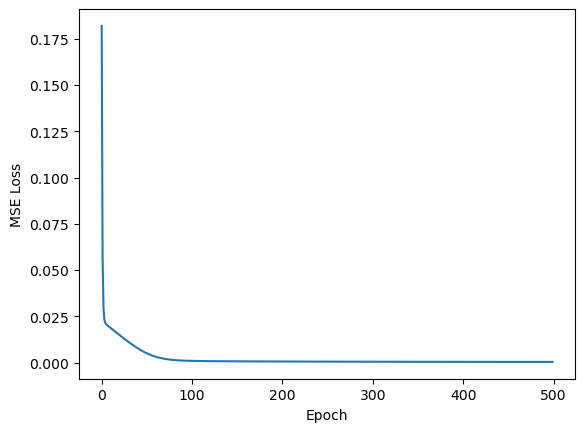

In [17]:
plt.plot(np.array(e), np.array(l))
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

In [18]:
PATH = './wind_model.pth'
torch.save(model.state_dict(), PATH)

## Testing

In [19]:
model = LinearRegression(input_dim, hidden_dim, 1)
model.load_state_dict(torch.load(PATH))


with torch.no_grad():
    loss = 0
    predictions = model(X_test)
    labels = torch.from_numpy(y_scaler.inverse_transform(Y_test))
    predictions = torch.from_numpy(y_scaler.inverse_transform(predictions))
    loss += nn.functional.mse_loss(predictions, labels)
    print(f'MSE Loss: {loss / (i + 1):.5f}')

MSE Loss: 0.00008
